# Deploy

**Note the max blob size is INT_MAX ~ 2GB** accordingly, the input might have to be resized. The network works as-is if the image `h` and `w` are both such that 

`2^n % [h,w] = 0, for integers n`

To use other input sizes it might be necessary to modify the `Upsample` layer definitions.


In [18]:
import sys
import numpy as np
import os
import cv2
import glob
import time

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
from skimage import exposure
from scipy import ndimage

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
import caffe
caffe.set_mode_cpu()

In [12]:
netdef = '/home/nathan/caffe-segnet-crf/notebooks_ubuntu/models/deploy-SegNet-CRFRNN.prototxt'
weight = '/home/nathan/histo-seg/semantic-pca/weights/segnet-crfrnn/crfrnn_iter_15000.caffemodel'

net = caffe.Net(netdef, weight, caffe.TEST)

In [4]:
# http://www.pyimagesearch.com/2015/11/02/watershed-opencv/
# Really, really don't like this procedure. It should be much cleaner.

def process_prob(img, prob, dist=11):
    prob = cv2.convertScaleAbs(prob)
    _, prob_thresh = cv2.threshold(prob, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    D = ndimage.distance_transform_edt(prob_thresh)
    localMax = peak_local_max(D, indices=False, min_distance=dist,
                              labels=prob_thresh)
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=prob_thresh)

    marked_img = mark_boundaries(img, labels)
    
    return marked_img

In [12]:
imglist = glob.glob('/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original/*.tif')

start_time = time.clock()
# imgpath = np.random.choice(imglist)
for k, imgpath in enumerate(imglist):
    if k % 50 == 0:
        print 'Working image {}'.format(k)
    img_ = cv2.imread(imgpath)
    img_ = img_[:, :, ::-1]  # BGR --> RGB
    img_ = cv2.resize(img_, dsize=(512, 512))

    img = img_.transpose((2,0,1))
    img = np.expand_dims(img, 0)
#     print img.shape

    # net.blobs['data'].data[...] = img

    _ = net.forward(data=img, end='conv_classifier')

    seg_1 = np.squeeze(net.blobs['conv_classifier'].data[0,1,:,:])
#     crfrnn_1 = np.squeeze(net.blobs['crfrnn'].data[0,1,:,:])

#     marked_seg = process_prob(img_, seg_1, 11)
#     marked_crfrnn = process_prob(img_, crfrnn_1)

#     write_path = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/segnet'
#     write_name = os.path.join(write_path, os.path.basename(imgpath).replace('.tif', 'seg.png'))
#     cv2.imwrite(write_name, marked_seg[:, :, ::-1]*255)

#     write_path = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/comp_seg'
#     write_name = os.path.join(write_path, os.path.basename(imgpath).replace('.tif', 'crf.png'))
#     cv2.imwrite(write_name, marked_crfrnn[:, :, ::-1]*255)
    
end_time = time.clock()
elapsed = end_time - start_time

print 'Processed {} images in {}s'.format(k, elapsed)

Working image 0
Working image 50
Working image 100


KeyboardInterrupt: 

# Process one

prob: (5, 512, 512)
Processed in 4.111279s


[]

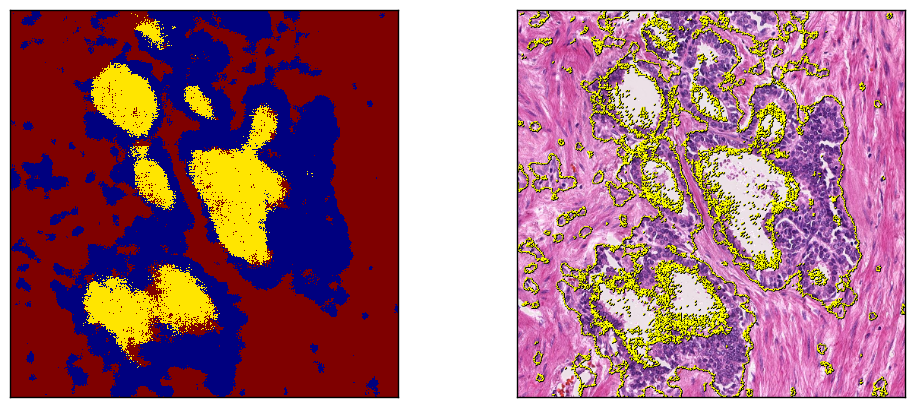

In [17]:
imglist = glob.glob('/home/nathan/histo-seg/semantic-pca/data/source_validate/jpg/*.jpg')

start_time = time.clock()
imgpath = np.random.choice(imglist)
img_ = cv2.imread(imgpath)
img_ = img_[:, :, ::-1]  # BGR --> RGB
img_ = cv2.resize(img_, dsize=(512, 512))

img = img_.transpose((2,0,1))
img = np.expand_dims(img, 0)

_ = net.forward(data=img)

prob = np.squeeze(net.blobs['conv_classifier'].data[0,:,:,:])
print 'prob: {}'.format(prob.shape)
cls = np.argmax(prob, axis=0)
# marked_seg = process_prob(img_, prob, 11)
    
marked_img = mark_boundaries(img_, cls)
end_time = time.clock()
elapsed = end_time - start_time

print 'Processed in {}s'.format(elapsed)

fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].matshow(cls)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(marked_img)
ax[1].set_xticks([])
ax[1].set_yticks([])

elapsed 0.23141 


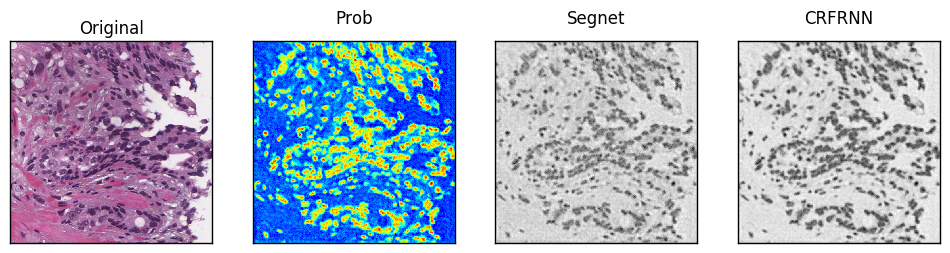

In [21]:

start_time = time.clock()
fig, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(img_); ax[0].set_title('Original'); ax[0].set_yticks([]); ax[0].set_xticks([])

ax[1].matshow(np.squeeze(net.blobs['crfrnn'].data[0,1,:,:]))
ax[1].set_title('Prob'); ax[1].set_yticks([]); ax[1].set_xticks([])

# ax[2].matshow(np.argmax(np.squeeze(net.blobs['conv_classifier'].data[0,:,:,:]), axis=0), cmap='Greys')
# ax[2].set_title('Segnet'); ax[2].set_yticks([]); ax[2].set_xticks([])
ax[2].matshow(np.squeeze(net.blobs['conv_classifier'].data[0,1,:,:]), cmap='Greys')
ax[2].set_title('Segnet'); ax[2].set_yticks([]); ax[2].set_xticks([])

# ax[3].matshow(np.argmax(np.squeeze(net.blobs['crfrnn'].data[0,:,:,:]), axis=0), cmap='Greys')
# ax[3].set_title('CRFRNN'); ax[3].set_yticks([]); ax[3].set_xticks([])
ax[3].matshow(np.squeeze(net.blobs['crfrnn'].data[0,1,:,:]), cmap='Greys')
ax[3].set_title('CRFRNN'); ax[3].set_yticks([]); ax[3].set_xticks([])

end_time = time.clock()
elapsed = end_time - start_time

print 'elapsed {} '.format(elapsed)